In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 
import numpy as np
import yaml
from copy import deepcopy
from scipy.constants import physical_constants
from scipy.interpolate import griddata
from scipy.integrate import quad as quadint
from pmd_beamphysics import ParticleGroup
import os

e0 = physical_constants['vacuum electric permittivity'][0]

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Functions for Creating Particles
---

In [2]:
from distgen import Generator

# Creates a beam in the rest frame 

DISTGEN_FILE_STR="""
n_particle: 1000000
random_type: hammersley
start:
  tstart:
    units: sec
    value: 0
  type: time
total_charge:
  units: nC
  value: 0.01
transforms:
  t1:
    avg_pz: 
      value: 0
      units: MeV/c
    type: set_avg pz
"""

In [3]:
def get_initial_particles(A,                # Aspect ratio
                          dist='gaussian',  # Dist type Gaussian or Uniform
                          stdz=1,           # sigma_z, used to get sigma_xy fromA
                          use_witness_particles=True,
                          verbose=False
                         ):          
    
    stdxy = A*stdz # [stdz] = mm here, but elsewhere likely [m]
    
    inputs = yaml.safe_load(DISTGEN_FILE_STR)
    
    if(dist=='gaussian'):
        
        inputs['r_dist'] = {'type':'radial_gaussian', 'sigma_xy':{'value': stdxy, 'units':'mm'}}
        inputs['z_dist'] = {'type':'gaussian', 'sigma_z':{'value': stdz, 'units':'mm'}}
        
    elif(dist=='uniform'):
        
        inputs['r_dist'] = {'type':'radial_uniform', 'max_r':{'value': 2*stdxy, 'units':'mm'}}
        inputs['z_dist'] = {'type':'uniform', 
                            'sigma_z':{'value': stdz, 'units':'mm'},
                            'avg_z':{'value': 0, 'units':'mm'},}
    
    gen = Generator(inputs, verbose=False)
    gen.run()
    beam = gen.particles
    
    if(use_witness_particles):
    
        # Create q=0 witness particles
        zs = (stdz*1e-3)*np.linspace(-5, 5, 501)
        ws = np.zeros(zs.shape)      # Weights
        ss = np.full(zs.shape, 1)    # Status

        witness_particles = ParticleGroup(data={'x':ws,
                                                'px':ws,
                                                'y':ws,
                                                'py':ws,
                                                'z':zs, 
                                                'pz':ws,
                                                'weight':ws, 
                                                't':ws,
                                                'status':ss, 
                                                'species':'electron'})

        beam = beam + witness_particles
    
    if(verbose):
        print('Initial particle beam stats:')
        for v in ['x', 'y', 'z', 't', 'px', 'py', 'pz']:
            avg_str, std_str = f'mean_{v}', f'sigma_{v}'
            print(f'{v}: avg = {beam[avg_str]:0.3e}, std = {beam[std_str]:0.3e}')
        
        print(f'Aspect ratio: {beam["sigma_x"]/beam["sigma_z"]:0.3e}')
        print( "Number of witness particles:", len(beam.weight[beam.weight==0]) )
        print( "Number of active particles:", len(beam.weight[beam.weight>0]) )
        
    return beam


Initial particle beam stats:
x: avg = -5.639e-20, std = 1.000e-03
y: avg = 5.238e-20, std = 1.000e-03
z: avg = 1.921e-20, std = 1.000e-03
t: avg = 0.000e+00, std = 0.000e+00
px: avg = 0.000e+00, std = 0.000e+00
py: avg = 0.000e+00, std = 0.000e+00
pz: avg = 0.000e+00, std = 0.000e+00
Aspect ratio: 1.000e+00
Number of witness particles: 501
Number of active particles: 1000000


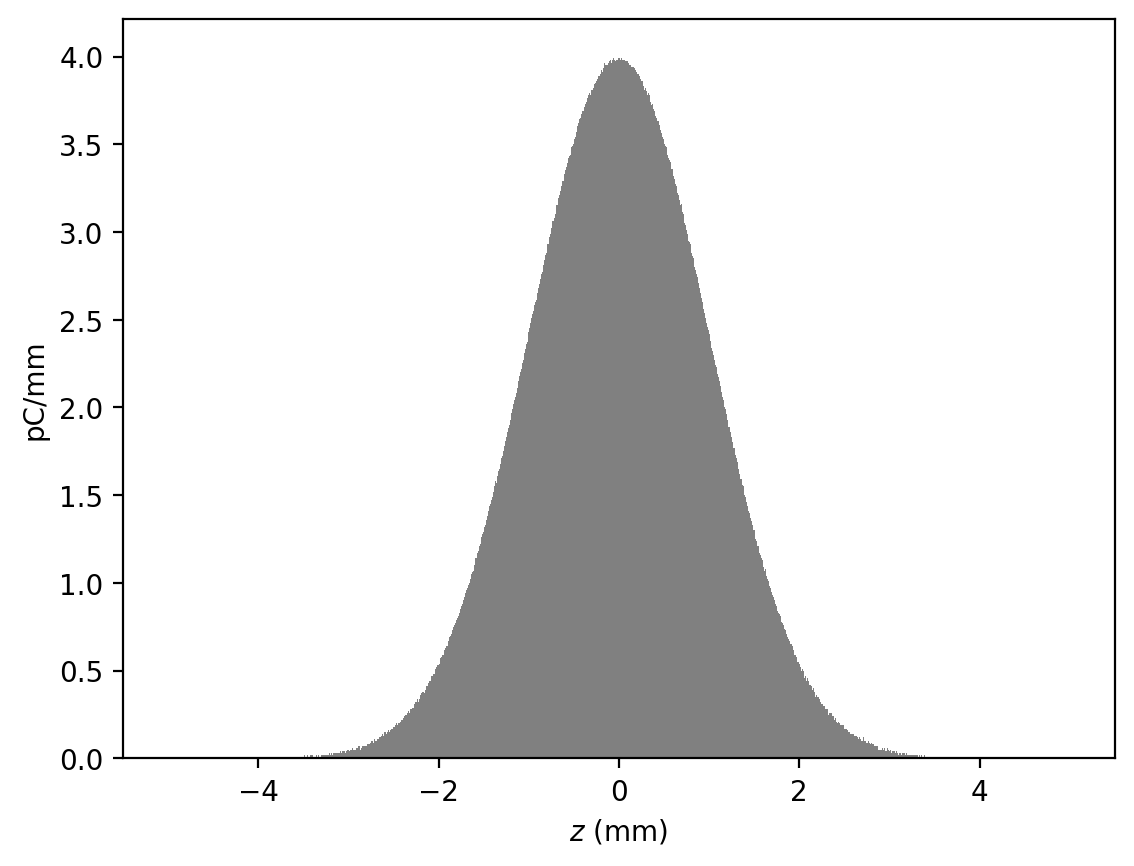

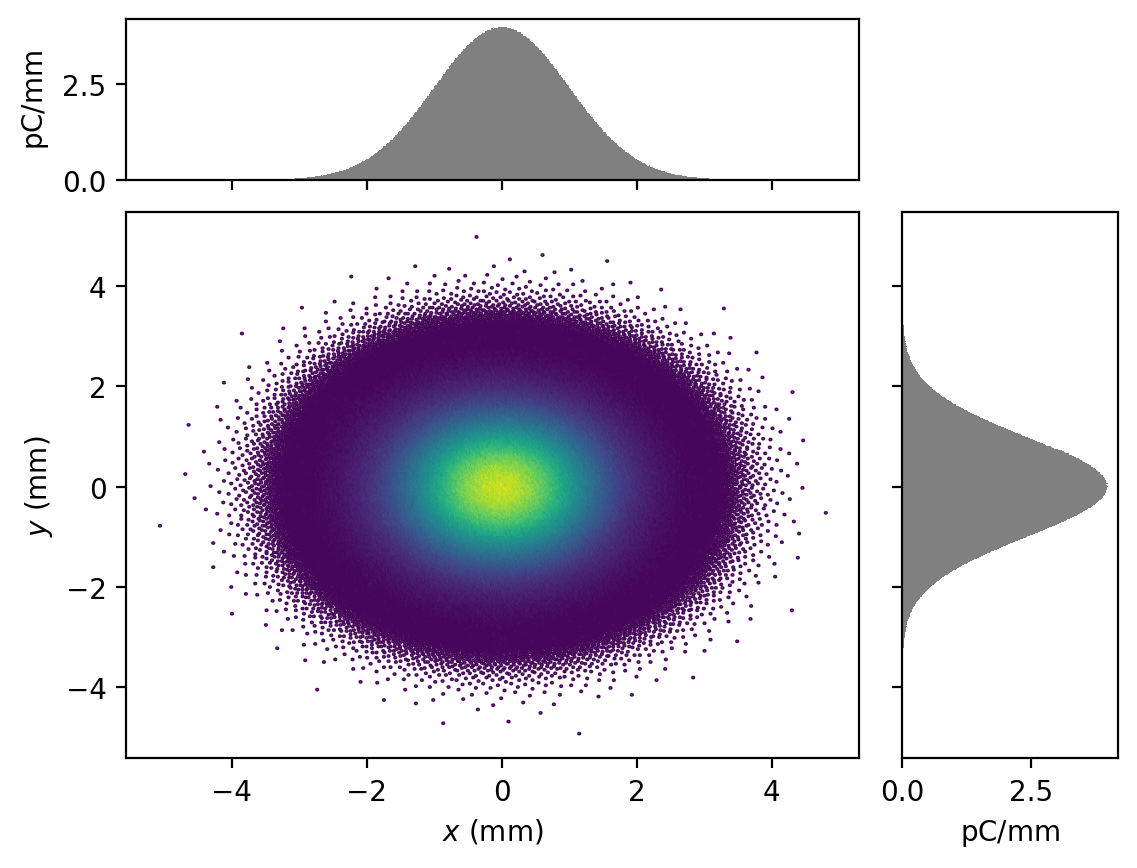

In [4]:
GP = get_initial_particles(1, verbose=True)
GP.plot('z')
GP.plot('x', 'y')

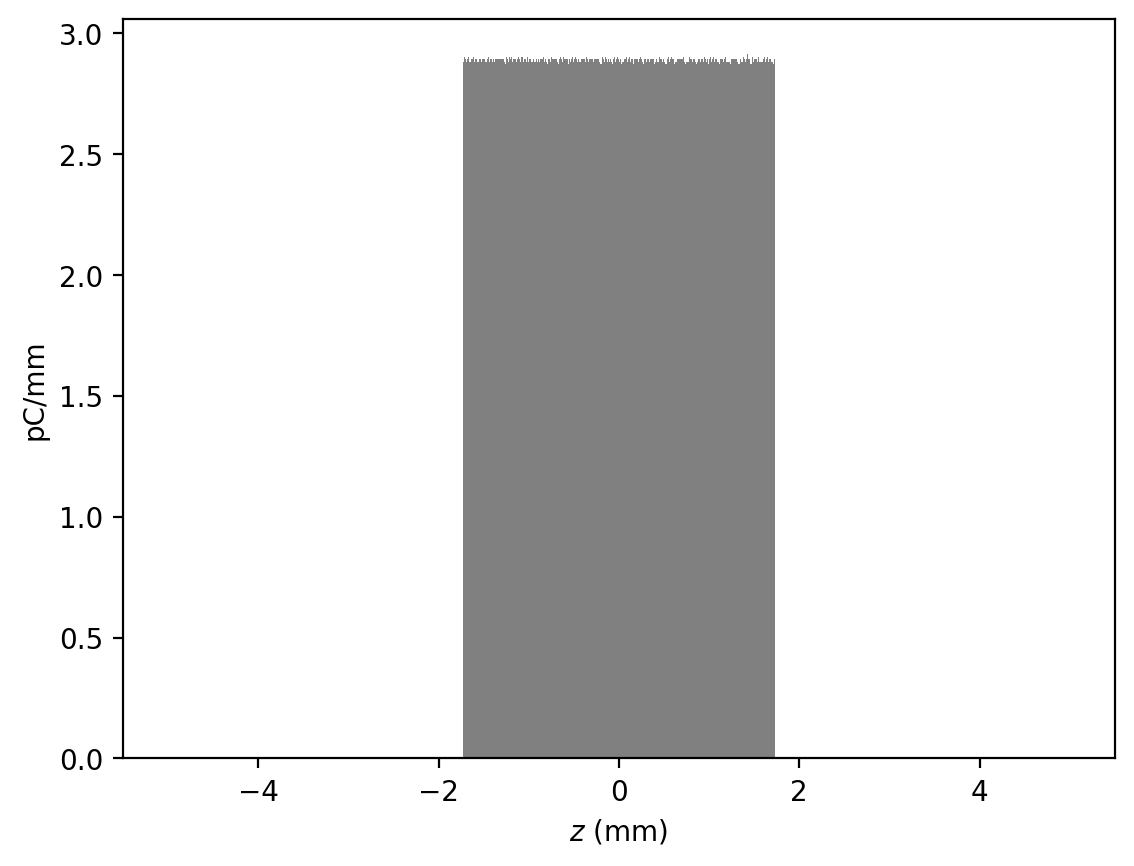

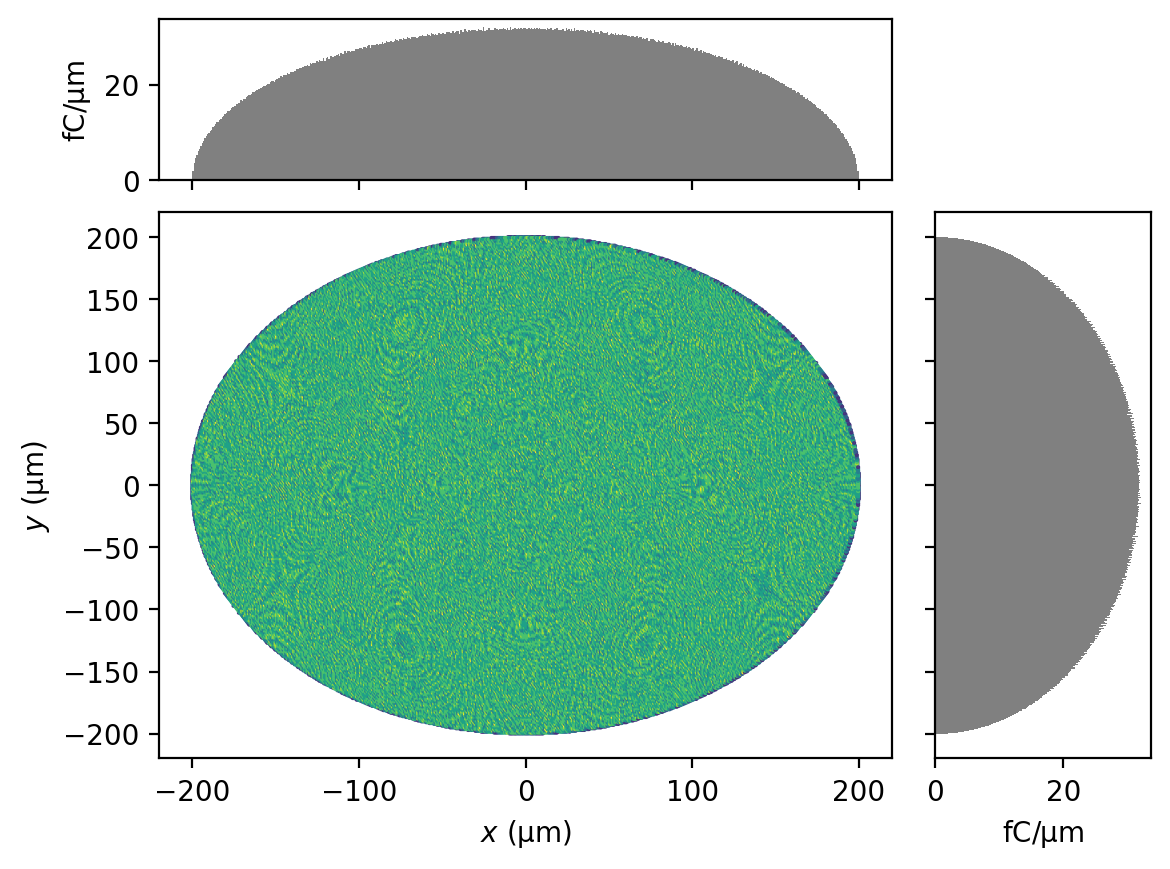

In [5]:
UP = get_initial_particles(0.1, dist='uniform')
UP.plot('z')
UP.plot('x', 'y')

# Functions for Running GPT to get LSC Fields
---

In [6]:
from gpt import GPT

GPT_SETTINGS = {
    'space_charge': 1,
    'cathode': 0,
    'Alpha': 2.0,
    'Fn':  0.0,
    'verror':  0.005,
    'Nstd':  8,
    'tmax': 0.5e-12,
    'dtmin': 0.5e-13,
    'ZSTART':-5.0,
    'ZSTOP':+5.0,
}



def write_gpt_file():
   
    lines="""time=0.0;
setfile("beam", "gpt.particles.gdf");
RadiusMax=0.04;
GBacc=5.5;
xacc=6.5;
accuracy(GBacc, xacc);
dtmin=5e-14;
dtmax=1e-10;
scr1_z=0.0;
#screen("wcs", "I", scr1_z);
Alpha=1.5;
Fn=0.1;
verror=0.005;
Nstd=5;
spacecharge3Dmesh("MeshNfac", Alpha, "MeshAdapt", Fn, "SolverAcc", verror, "MeshBoxSize", Nstd);
ZSTART=-5.0;
ZSTOP=5.0;
zminmax("wcs", "I", ZSTART, ZSTOP);
tout(0.0e-13);
tmax=2e-12;
"""
    
    with open('gpt.in', 'w') as fid:
        fid.write(lines)

def run_gpt(particles, settings=GPT_SETTINGS, verbose=False, gpt_verbose=False):
    
    if(verbose):
        print(f'GPT meshing: Nx = Ny = Nz = {int(GPT_SETTINGS["Alpha"]*len(particles["x"])**0.3)}')
    
    write_gpt_file()
    
    G = GPT(input_file='gpt.in', 
        initial_particles=particles,
        load_fields=True,
        verbose=verbose,)
        #use_tempdir=False, workdir='temp')  # Make a temp dir to run scratch work in

    G.set_variables(settings)
    G.run(gpt_verbose=gpt_verbose)
    
    os.remove('gpt.in')
    
    # Make sure the particles didn't move, tout should happen on first step:
    for v in ['x', 'y', 'z', 't', 'px', 'py', 'pz']:
        if(max(np.abs(particles[v]-G.tout[0][v]))>1e-14):
            print(f'warning: particle coordinate {v} may have changed: delta = {particles[v]-G.tout[0][v]}')
            
    if(verbose):
        print('Final particle beam stats:')
        for v in ['x', 'y', 'z', 't', 'px', 'py', 'pz']:
            avg_str, std_str = f'mean_{v}', f'sigma_{v}'
            print(f'{v}: avg = {G.tout[0][avg_str]:0.3e}, std = {G.tout[0][std_str]:0.3e}')
        
        print(f'Aspect ratio: {G.tout[0]["sigma_x"]/G.tout[0]["sigma_z"]:0.3e}')
        print( "Number of witness particles:", len(G.tout[0].weight[G.tout[0].weight==0]) )
        print( "Number of active particles:", len(G.tout[0].weight[G.tout[0].weight>0]) )
    
    
    
    return G

In [7]:
def get_gpt_Ez_on_axis(G):
    
    P = G.tout[0]
    F = G.fields[0]
    
    r, z = P['r'], P['z']
    
    if(len(z[r==0])>10):  # Should be witness particles, just use those 
        
        zs = z[r==0]
        Ez0s = F['Ez'][r==0]
    
    else:
    
        stdx, stdy, stdz = G.initial_particles['sigma_x'], G.initial_particles['sigma_y'], G.initial_particles['sigma_z']

        x, y, z, Ez = G.tout[0]['x'], G.tout[0]['y'], G.tout[0]['z'], G.fields[0]['Ez']

        Nz = 101
        
        xs = stdx*np.linspace(-1, 1, 101)
        ys = stdx*np.linspace(-1, 1, 101)
        zs = stdz*np.linspace(-5, 5, Nz)
        xx, yy, zz =  np.meshgrid( xs, ys, zs)

        Ezs = griddata((x,y,z), Ez, (xx, yy, zz), method='linear')
        Ez0s = np.squeeze(Ezs[int(Nz/2), int(Nz/2), :])
        
        not_nan = ~np.isnan(Ez0s)
        
        zs, Ez0s = zs[not_nan], Ez0s[not_nan]

    return zs, Ez0s
    

To compare the LSC fields $E_z$ from GPT to an analytic model $E_{z,0}$, use relative average error:

$\epsilon_{rel} = \frac{\int_0^{\infty} (E_z - E_{z,0})dz}{\int_0^{\infty}E_{z,0}dz}$

In [8]:
def relative_avgEz_error(G, dist, use_witness_particles=True):

    z, Ez = get_gpt_Ez_on_axis(G)
    
    stdxy = G.initial_particles['sigma_x']
    stdz = G.initial_particles['sigma_z']
    q = -G.initial_particles.charge
    
    if(dist=='gaussian'):
        
        rho = np.exp(-(z/stdz)**2/2.0)
        Ez0 = GaussianEz(q, stdxy, stdz, z) 
        
    elif(dist=='uniform'):
        
        L = np.sqrt(12)*stdz
        rho = np.zeros(z.shape)
        rho[ (z >= -L/2.0) & (z <= +L/2.0) ] = 1
        Ez0 = UniformEz(q, stdxy, stdz, z) 
           
    rho = rho/np.trapz(rho, z) 
    delta = (np.abs(Ez) - np.abs(Ez0))

    return np.trapz(delta*rho, z) / np.trapz(np.abs(Ez0)*rho, z)

In [9]:
def plot_fields(G, dist):
    
    r_all = G.tout[0]['r']
    z_all = G.tout[0]['z']
    
    zmin, zmax = min(z_all[r_all>0]), max(z_all[r_all>0])
    
    z, Ez = get_gpt_Ez_on_axis(G)
    
    #print(z[0], z[-1], z_all[-501], z_all[-1])
    
    stdxy = G.initial_particles['sigma_x']
    stdz = G.initial_particles['sigma_z']
    q = -G.initial_particles.charge
    A = +G.tout[0]['sigma_x']/G.tout[0]['sigma_z']
    
    if(dist=='gaussian'):
        
        rho = np.exp(-(z/stdz)**2/2.0)
        Ez0 = GaussianEz( q, stdxy, stdz, z) 
        
    elif(dist=='uniform'):
        
        L = np.sqrt(12)*stdz
        rho = np.zeros(z.shape)
        rho[ (z >= -L/2.0) & (z <= +L/2.0) ] = 1
        Ez0 = UniformEz(q, stdxy, stdz, z) 
        
    rho = rho/np.trapz(rho, z) 
    
    in_bunch = (z>=zmin) & (z<=zmax)  
    zw = z[~in_bunch]
    Ezw = Ez[~in_bunch]
    
    zb = z[in_bunch]
    Ezb = Ez[in_bunch]
    
    rhob_hist, zb_edges = np.histogram(z_all[r_all>0], bins=100, density=True)
    rhob_hist = rhob_hist
    zbc = (zb_edges[1:] + zb_edges[:-1]) / 2
    rhob_hist = rhob_hist/np.trapz(rhob_hist, zbc)

    plt.title(f'Aspect ratio: {A:0.2e}, $\sigma_z: {1e3*stdz:0.2f}$ mm, Active Q = {1e9*q:0.2f} nC')
    
    plt.plot(zw/stdz, Ezw/1e6, '.', color='red') 
    plt.plot(zb/stdz, Ezb/1e6, '.', color='tab:orange')
    plt.plot(z/stdz, Ez0/1e6, color='tab:blue')
    plt.xlabel('z/$\sigma_z$')
    plt.ylabel('$E_z(r=0)$ (MV/m)')
    plt.legend(['Outside bunch', 'Inside Bunch', 'Analytic'])
    
    ax = plt.gca()
    ax2=ax.twinx()
    
    # Get only dudes in the bunch
    rhob = rho[in_bunch]
    rhob = rhob/np.trapz(rhob, zb) # Renorm
    
    #print(np.trapz(rhob, zb), np.trapz(rhob_hist, zbc))
    
    zb = np.append(zb, zb[-1])
    rhob = np.append(rhob, 0)
    
    zb = np.insert(zb, 0, zb[0])
    rhob = np.insert(rhob, 0, 0)
    
    ax2.plot(zbc/stdz, rhob_hist, 'k')
    #ax2.plot(zb/stdz, rhob, color='k', alpha=0.25)
    ax2.fill_between(zb/stdz, rhob, alpha=0.25, color='k')
    ax2.set_ylabel('$\\rho(r=0,z)$ (pC/mm)')
    ax2.set_ylim([0, 1.2*max(rhob)])


    

# Analytic Functions for LSC Fields in Rest Frame
---

## Gaussian Bunch
The on-axis longitudinal spacecharge field of a cylindrically symmetric Gaussian bunch is

$E_z(r=0) = \frac{Q}{4\pi\epsilon_0\sigma_z^2}\sqrt{\frac{2}{\pi}}\left(\frac{z}{\sigma_z}\right)\int_0^{\infty}\frac{\alpha^2}{(A^2\alpha^2+1)(\alpha^2+1)^{3/2}}\exp\left(-\frac{\alpha^2}{(\alpha^2+1)}\frac{z^2}{2\sigma_z^2}\right)d\alpha$,

where the aspect ratio A is given by $A = \sigma_{x,y}/\sigma_z$.

In [15]:
def dEzda0(q, stdxy, stdz, z, a):
    
    A = stdxy/stdz
    
    az = (a**2 + 1) 
    axy = (a**2 * A**2 +1)
    
    F = (q/4/np.pi/e0/stdz**2)*np.sqrt(2/np.pi)*(z/stdz)*a**2
    D = axy*az**(3/2)
    
    return (F/D)*np.exp( -(a**2/az)*(z/stdz)**2/2)
    
def GaussianEzSinglePt(q, stdxy, stdz, zpt):

    if(zpt==0):
        return 0
    else:
        return quadint(lambda a: dEzda0(q, stdxy, stdz, zpt, a), 0, np.inf)[0]
    
def GaussianEz(q, stdxy, stdz, z, tol=1e-4):
    return np.array([GaussianEzSinglePt(q, stdxy, stdz, zpt) for zpt in z])
    
    

## Uniform Cylinder Bunch
The on-axis longitudinal spacecharge field for a uniform cylinder beam with length $L$ and radius $R$ is given by:

$E_z(r=0) = \frac{Q}{2\pi\epsilon_0R^2}\left(\sqrt{(1-\zeta)^2 + \tilde{A}^2} - \sqrt{\zeta^2 + \tilde{A}^2} - |1-\zeta| + |\zeta|\right)$

where $\zeta = \frac{z}{L} + \frac{1}{2}$ and the aspect ratio $\tilde{A} = R/L$.

In [11]:
def UniformEz(q, stdxy, stdz, z):
    
    R = 2*stdxy
    L = np.sqrt(12)*stdz
    Ap = R/L
    
    zeta = z/L + 1/2
    f = 1-zeta
    
    H = np.sqrt(f**2 + Ap**2) - np.sqrt(zeta**2 + Ap**2) + np.abs(zeta) - np.abs(f)
    
    return (q/2.0/np.pi/e0/R**2)*H
    

# Basic Test Cases: 
## Gaussian:

In [12]:
#GP = get_initial_particles(1, use_witness_particles=False, verbose=False)
#GG = run_gpt(GP, gpt_verbose=True)

In [13]:
#plot_fields(GG, 'gaussian')

GPT meshing: Nx = Ny = Nz = 126
GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/GitHub/lume-gpt/examples"
   Configured to run in "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp0rmfw0nb"
GPT.run_gpt:
   Initial 1000501 particles written to "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp0rmfw0nb/gpt.particles.gdf"
   Running GPT...
   Writing gpt input file to "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp0rmfw0nb/gpt.in"
   Running with timeout = None sec.
Parsing: /var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp0rmfw0nb/gpt.in
Reading 1000501 particle coordinates from "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp0rmfw0nb/gpt.particles.gdf" in group ""
Coordinate system "wcs" contains 0 local, 1 global and 0 boundary elements
Particle set "beam" contains 1000501 particles (0 particles with t>tstart)
Starting time is set to 0.000000e+00
Starting timestep is set to 3.335641e-12
Tout at 0.000000e+00 written
1000501: t=0.000000e+

-0.3224250585392313

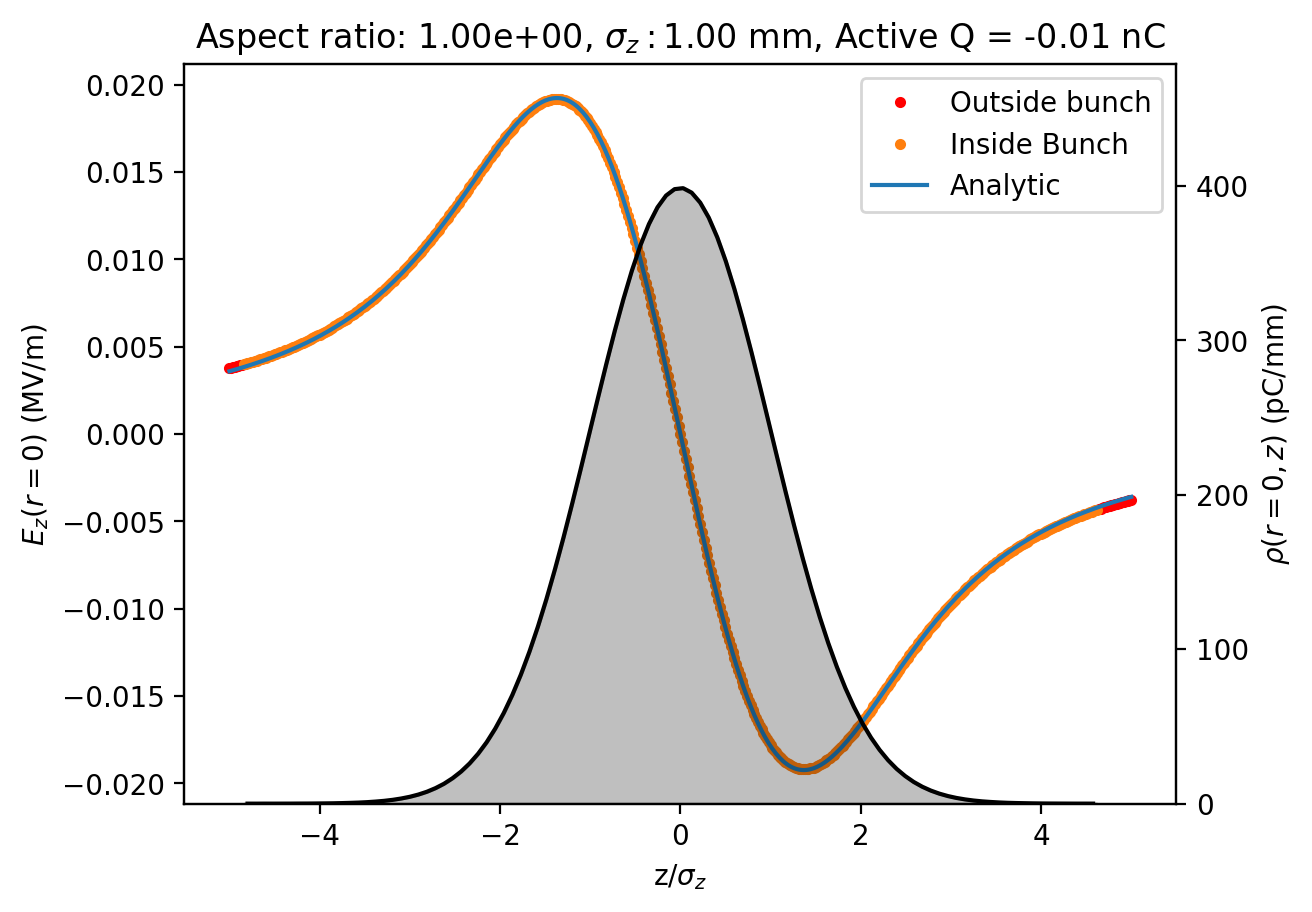

In [16]:
GP = get_initial_particles(1, use_witness_particles=True)
GG = run_gpt(GP, gpt_verbose=True, verbose=True)
plot_fields(GG, 'gaussian')
100*relative_avgEz_error(GG, 'gaussian')

GPT meshing: Nx = Ny = Nz = 126
GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/GitHub/lume-gpt/examples"
   Configured to run in "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp3spwp9dq"
GPT.run_gpt:
   Initial 1000501 particles written to "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp3spwp9dq/gpt.particles.gdf"
   Running GPT...
   Writing gpt input file to "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp3spwp9dq/gpt.in"
   Running with timeout = None sec.
Parsing: /var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp3spwp9dq/gpt.in
Reading 1000501 particle coordinates from "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp3spwp9dq/gpt.particles.gdf" in group ""
Coordinate system "wcs" contains 0 local, 1 global and 0 boundary elements
Particle set "beam" contains 1000501 particles (0 particles with t>tstart)
Starting time is set to 0.000000e+00
Starting timestep is set to 3.335641e-12
Tout at 0.000000e+00 written
1000501: t=0.000000e+

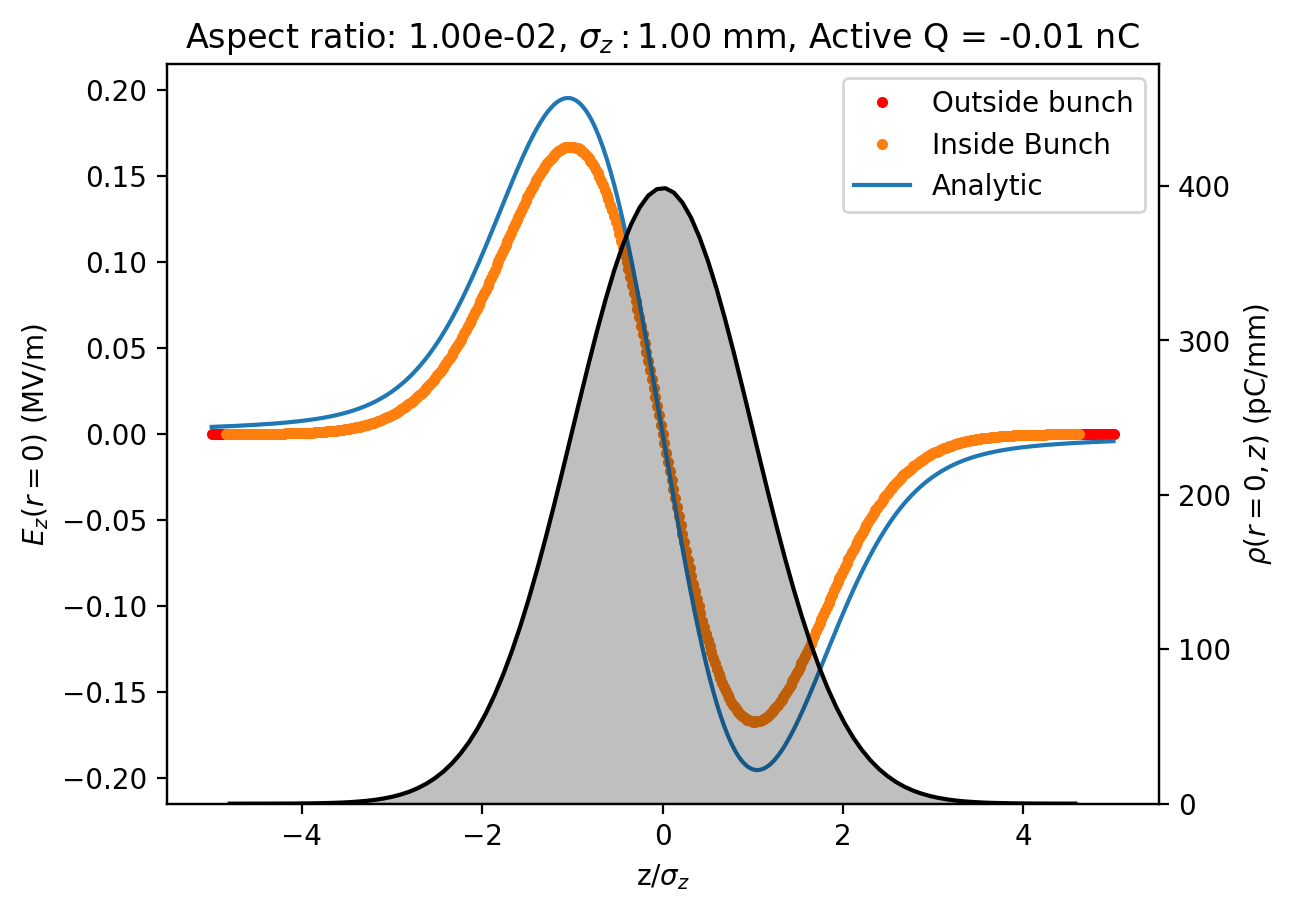

In [17]:
GP = get_initial_particles(0.01, use_witness_particles=True)
GG = run_gpt(GP, gpt_verbose=True, verbose=True)
plot_fields(GG, 'gaussian')

In [18]:
100*relative_avgEz_error(GG, 'gaussian')

-14.785948286620787

## Uniform

In [19]:
UP = get_initial_particles(1, dist='uniform')
UG = run_gpt(UP)

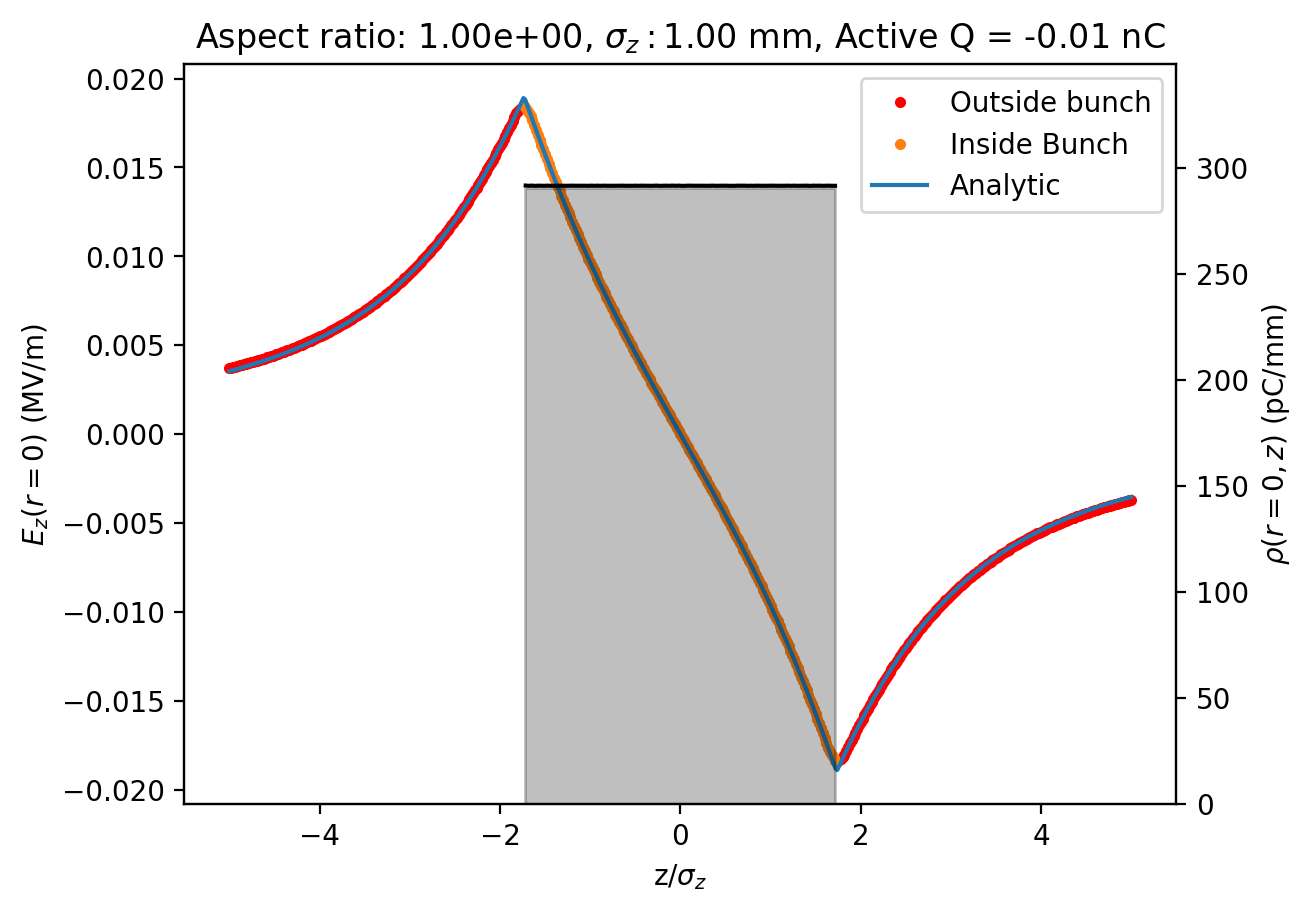

In [20]:
plot_fields(UG, 'uniform')

GPT meshing: Nx = Ny = Nz = 126
GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/GitHub/lume-gpt/examples"
   Configured to run in "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp6wxjm_hp"
GPT.run_gpt:
   Initial 1000501 particles written to "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp6wxjm_hp/gpt.particles.gdf"
   Running GPT...
   Writing gpt input file to "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp6wxjm_hp/gpt.in"
   Running with timeout = None sec.
Parsing: /var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp6wxjm_hp/gpt.in
Reading 1000501 particle coordinates from "/var/folders/ry/l_d12g5s69n2r0nvb1xy0hhm0000gn/T/tmp6wxjm_hp/gpt.particles.gdf" in group ""
Coordinate system "wcs" contains 0 local, 1 global and 0 boundary elements
Particle set "beam" contains 1000501 particles (0 particles with t>tstart)
Starting time is set to 0.000000e+00
Starting timestep is set to 3.335641e-12
Tout at 0.000000e+00 written
1000501: t=0.000000e+

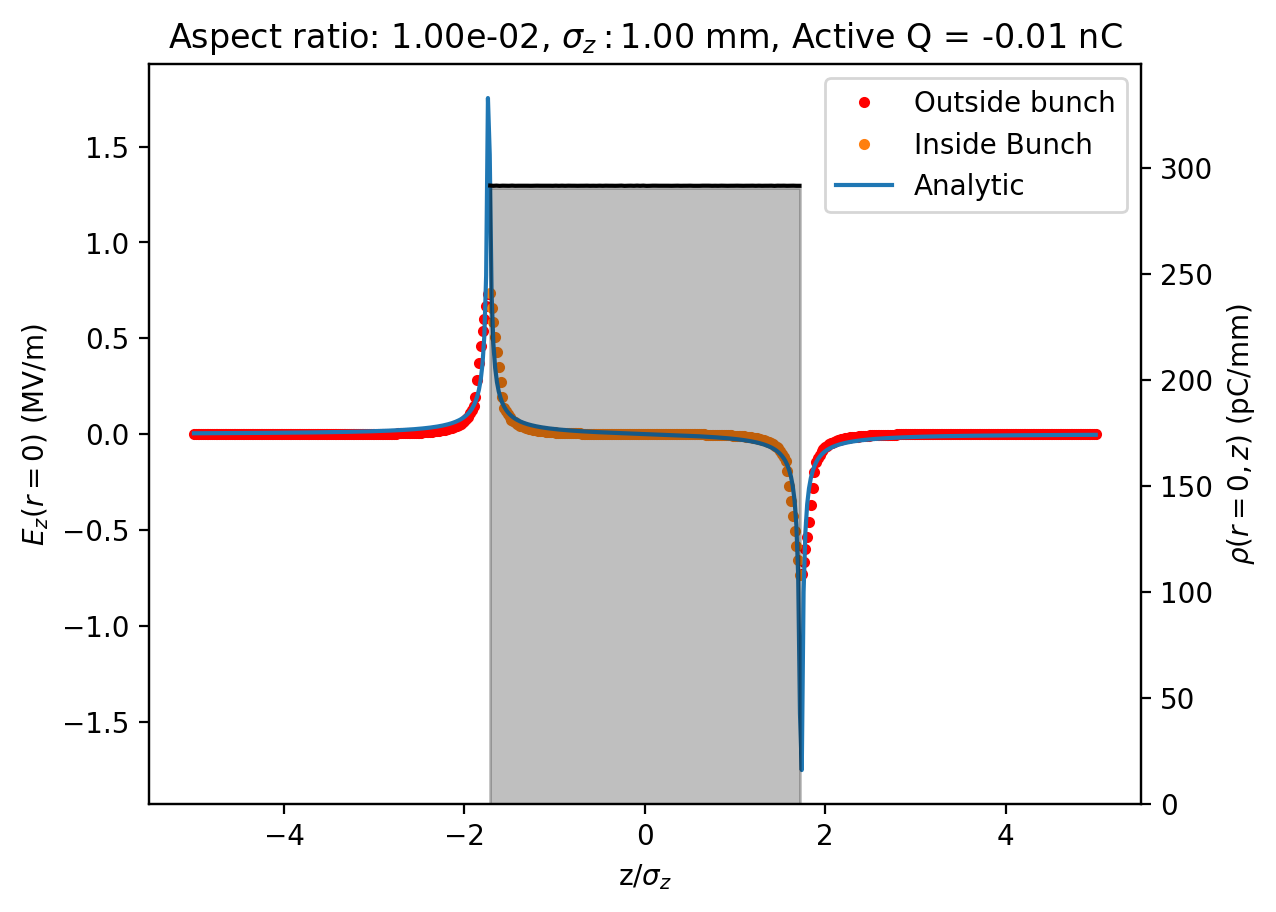

In [21]:
UP = get_initial_particles(0.01, dist='uniform')
UG = run_gpt(UP, verbose=True, gpt_verbose=True)
plot_fields(UG, 'uniform')

In [22]:
100*relative_avgEz_error(UG, 'uniform')

-17.832531515563556

In [23]:
def scan_aspect_ratio(As=[1], dist='gaussian'):
    
    rel_errors = np.zeros(len(As))
    
    for ii, A in enumerate(As):
        
        print(f'A = {A:0.3f}, % done = {int(100*ii/len(As)):0.1f}')
        
        P = get_initial_particles(A, dist=dist)
        G = run_gpt(P)
        rel_errors[ii] = relative_avgEz_error(G, dist)
        
    return rel_errors

In [ ]:
#As = [0.001, 0.01, 0.1,1, 10, 100, 1000]
As = np.logspace(-3, 3, 100)
rel_errorsG = scan_aspect_ratio(As=As)

A = 0.001, % done = 0.0
A = 0.001, % done = 1.0
A = 0.001, % done = 2.0
A = 0.002, % done = 3.0
A = 0.002, % done = 4.0
A = 0.002, % done = 5.0
A = 0.002, % done = 6.0
A = 0.003, % done = 7.0
A = 0.003, % done = 8.0
A = 0.004, % done = 9.0
A = 0.004, % done = 10.0
A = 0.005, % done = 11.0


In [ ]:
#As = As[rel_errors<max(rel_errors)]
#rel_errors = rel_errors[rel_errors<max(rel_errors)]
plt.plot(As, 100*rel_errorsG)
#plt.plot(As, mez1/1e6, '.', color='tab:blue')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Aspect Ratio $\sigma_{x,y}/\sigma_{z}$');
plt.ylabel('Integrated Field Error (%)');
#plt.legend(['Analytic', 'GPT']);

In [ ]:
rel_errorsU = scan_aspect_ratio(As=As, dist='uniform')

In [ ]:
#As = As[rel_errorsU<max(rel_errorsU)]
#rel_errors = rel_errors[rel_errors<max(rel_errors)]
plt.plot(As, 100*rel_errorsG)
plt.plot(As, 100*rel_errorsU)
#plt.plot(As, mez1/1e6, '.', color='tab:blue')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Aspect Ratio $\sigma_{x,y}/\sigma_{z}$');
plt.ylabel('Integrated Field Error (%)');
plt.legend(['Gaussian', 'Uniform']);

($x, {~}\vec{p})\rightarrow(x, \vec{p} - \vec{p}_{\theta}$)

$\vec{p}_{\theta} = \frac{1}{r}(xp_y-yp_x)(-\sin\theta\hat{x} + \cos\theta\hat{y} )$

Canonical angular momentum conservation: $\mathcal{P}_{\theta} = L_z + \frac{1}{2}eB(z)r^2 = L_{z,0}$

$L_z = L_{z,0} - \frac{1}{2}eB\cdot r^2(z) $